In [1]:
import pandas as pd
Signupdata = pd.read_csv('/home/mvisi/Project/DLP/Core/FraudPredict/Notebook/Arpan/Signupdataimputed.csv', error_bad_lines=False)

In [2]:
#Seperating Dependent and independent variables 
#data_final_Org= data_final.copy()
Signupdata_ML = Signupdata.copy()
X_Signupdata = Signupdata.drop(['Fraud_Acc_Flag'], axis=1, inplace=True)
Y_Signupdata = Signupdata_ML.Fraud_Acc_Flag

In [3]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Signupdata, Y_Signupdata, test_size=0.30, random_state=42)

In [4]:
#Applying XGBoost Classification
import xgboost as xgb
XGBClassifier = xgb.XGBClassifier()
XGBClassifier.fit(X_train,y_train)

/home/mvisi/.local/lib/python3.6/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[04:30:34] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [5]:
from sklearn import model_selection, metrics
hardpredtst=XGBClassifier.predict(X_test)
def conf_matrix(y,pred):
    ((tn, fp), (fn, tp)) = metrics.confusion_matrix(y, pred)
    ((tnr,fpr),(fnr,tpr))= metrics.confusion_matrix(y, pred, 
            normalize='true')
    return pd.DataFrame([[f'TN = {tn} (TNR = {tnr:1.2%})', 
                                f'FP = {fp} (FPR = {fpr:1.2%})'], 
                         [f'FN = {fn} (FNR = {fnr:1.2%})', 
                                f'TP = {tp} (TPR = {tpr:1.2%})']],
            index=['True 0(Legit)', 'True 1(Fraud)'], 
            columns=['Pred 0(Approve as Legit)', 
                            'Pred 1(Deny as Fraud)'])
conf_matrix(y_test,hardpredtst)

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 124700 (TNR = 99.99%),FP = 11 (FPR = 0.01%)
True 1(Fraud),FN = 221 (FNR = 93.25%),TP = 16 (TPR = 6.75%)


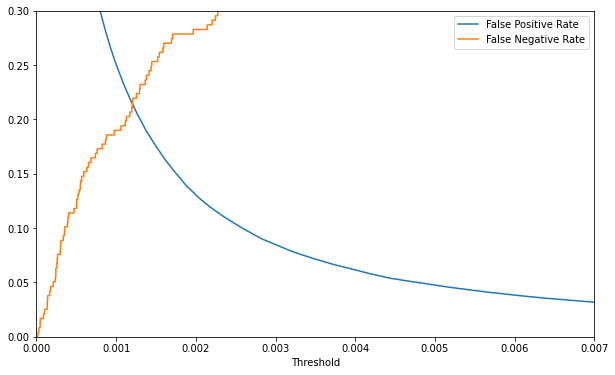

In [6]:
predtstXGBC=XGBClassifier.predict_proba(X_test)[:,1] #rerun again
fpr, tpr, thresholds = metrics.roc_curve(y_test, predtstXGBC)
dfplot=pd.DataFrame({'Threshold':thresholds, 
        'False Positive Rate':fpr, 
        'False Negative Rate': 1.-tpr})
ax=dfplot.plot(x='Threshold', y=['False Positive Rate',
        'False Negative Rate'], figsize=(10,6))
#ax.plot([0.00035,0.00035],[0,0.1]) #mark example thresh.
ax.set_xbound(0,0.0070); ax.set_ybound(0,0.3)

In [7]:
import numpy as np
hardpredtst_tuned_threshXGBC = np.where(predtstXGBC >= 0.0012035066029056907, 1, 0)
conf_matrix(y_test, hardpredtst_tuned_threshXGBC
        )

,Pred 0(Approve as Legit),Pred 1(Deny as Fraud)
True 0(Legit),TN = 97986 (TNR = 78.57%),FP = 26725 (FPR = 21.43%)
True 1(Fraud),FN = 51 (FNR = 21.52%),TP = 186 (TPR = 78.48%)


In [8]:
#import shapash
from shapash.explainer.smart_explainer import SmartExplainer

/home/mvisi/.local/lib/python3.6/site-packages/numba/core/errors.py:149: UserWarning:

Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9



In [9]:
label_dict = {0: "Non-Fraud", 1: "Fraud"}

In [10]:
xpl = SmartExplainer(label_dict=label_dict) # optional parameter, specifies label for features name

In [11]:
hardpredtst_tuned_threshXGBC_Pandas = pd.DataFrame(hardpredtst_tuned_threshXGBC, columns=['pred'], #index=X_test.reset_index(drop='True'))  
                                                   index=X_test.index)


In [12]:
xpl.compile(
    x=X_test,
    model=XGBClassifier,
    y_pred=hardpredtst_tuned_threshXGBC_Pandas
)

Backend: Shap TreeExplainer


In [13]:
xpl.to_pandas(max_contrib=3).head()

INFO:numexpr.utils:Note: NumExpr detected 16 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


,pred,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
226589,Non-Fraud,aza,56183,1.61225,location_Country_Fullcontact,4229,1.45146,source,3,0.34583
123932,Fraud,country_of_residence,177,-0.722988,aza,37081,0.642447,Ip_Carrier,5805,0.580232
413136,Fraud,reg_mode,3,0.968852,Ip_Latitude,51.533,0.627405,Ip_Routing_type,5,0.605626
354965,Non-Fraud,location_Country_Fullcontact,4425,1.06607,brwsr_lang,125,0.96833,Ip_Carrier,5792,-0.610266
84563,Non-Fraud,ad_campaign,93,0.815583,aza,22897,0.332252,turnover,0,0.304509


In [14]:
app = xpl.run_app(title_story='Fraud Prediction')

Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
INFO:root:Your Shapash application run on http://CD-ML-GPU:8050/
INFO:root:Use the method .kill() to down your app.


Dash is running on http://0.0.0.0:8050/



INFO:shapash.webapp.smart_app:Dash is running on http://0.0.0.0:8050/



 * Serving Flask app "shapash.webapp.smart_app" (lazy loading)
 * Environment: UAT
 * Debug mode: off


INFO:werkzeug: * Running on http://0.0.0.0:8050/ (Press CTRL+C to quit)
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:32] "GET / HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:32] "GET /assets/style.css?m=1617794827.6701946 HTTP/1.1" 304 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:32] "GET /assets/material-icons.css?m=1617794827.6661947 HTTP/1.1" 304 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:32] "GET /assets/jquery.js?m=1617794827.6661947 HTTP/1.1" 304 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:32] "GET /assets/main.js?m=1617794827.6661947 HTTP/1.1" 304 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:33] "GET /_dash-dependencies HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:33] "GET /_dash-layout HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:34] "GET /assets/shapash-fond-fonce.png HTTP/1.1" 304 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 04:37:34] "GET /assets/settings.png HTTP/1.1" 304 -
INFO:werkzeug:172.26

In [15]:
#Switch from SmartExplainer Object to SmartPredictor Object
predictor = xpl.to_smartpredictor()

In [16]:
#Save your predictor in Pickle File

predictor.save('SignupFraudShapash.pkl')

In [18]:
#Load your predictor in Pickle File
from shapash.utils.load_smartpredictor import load_smartpredictor
from shapash.data.data_loader import data_loading

predictor_load = load_smartpredictor('SignupFraudShapash.pkl')

In [22]:
new_x = {'EIDStatus': 0,
             'SanctionStatus': 0,
             'Ip_Latitude': 51.48805555,
             'Ip_Longitude': -3.69972221,
             'Ip_Carrier': 5173,
             'Ip_Connection_type': 4,
             'Ip_Line_Speed': 3,
             'Ip_Routing_type': 3,
             'IP_Anonymizer_status':3,
             'Fullcontact_Matched':0,
             'Social_Profiles_Count': 1,
             'gender_Fullcontact':0,
             'ageRange_Fullcontact':0,
             'location_Country_Fullcontact':0,
             'browser_online':5,
             'brwsr_lang':45,
             'brwsr_type':3,
             'brwsr_version': 129,
             'device_manufacturer':0,
             'device_name':0,
            'device_type':1,
         'device_os_type':8,
         'screen_resolution':185,
         'address_type':3,
         'aza':44389,
         'country_of_residence':77,
         'email_domain':15297,
         'region_suburb':0,
         'residential_status':0,
         'title':23,
         'ad_campaign':0,
         'affiliate_name':154,
         'branch':11,
         'channel':1,
         'keywords':4353,
         'op_country':0,
         'referral_text':0,
         'reg_mode':2,
         'search_engine':0,
         'source':40,
         'sub_source':195,
         'turnover':0,
         'txn_value':118

           }

In [25]:
new_x1 = {'EIDStatus': 0,
             'SanctionStatus': 0,
             'Ip_Latitude': 37.3305299999999,
             'Ip_Longitude': -121.83823,
             'Ip_Carrier': 1342,
             'Ip_Connection_type': 11,
             'Ip_Line_Speed': 1,
             'Ip_Routing_type': 3,
             'IP_Anonymizer_status':0,
             'Fullcontact_Matched':0,
             'Social_Profiles_Count': 1,
             'gender_Fullcontact':0,
             'ageRange_Fullcontact':0,
             'location_Country_Fullcontact':0,
             'browser_online':0,
             'brwsr_lang':0,
             'brwsr_type':0,
             'brwsr_version': 0,
             'device_manufacturer':0,
             'device_name':0,
            'device_type':0,
         'device_os_type':5,
         'screen_resolution':0,
         'address_type':3,
         'aza':38110,
         'country_of_residence':236,
         'email_domain':1335,
         'region_suburb':0,
         'residential_status':0,
         'title':23,
         'ad_campaign':61,
         'affiliate_name':154,
         'branch':11,
         'channel':1,
         'keywords':4469,
         'op_country':0,
         'referral_text':228,
         'reg_mode':2,
         'search_engine':0,
         'source':32,
         'sub_source':92,
         'turnover':0,
         'txn_value':24

           }

In [37]:
YPRED=XGBClassifier.predict_proba(Testdata)[:,1]
YPREDT = np.where(YPRED >= 0.0012035066029056907, 1, 0)
YPREDT_Pandas = pd.DataFrame(YPREDT, columns=['pred'], #index=X_test.reset_index(drop='True'))  
                                                   index=Testdata.index)

In [38]:
predictor_load.add_input(x=new_x1, ypred=YPREDT_Pandas)


In [39]:
predictor_load.data["ypred"]

,pred,proba
0,Fraud,0.011268


In [41]:
prediction_proba = predictor_load.predict_proba()
prediction_proba

,class_0,class_1
0,0.988732,0.011268


INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:12:17] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:12:24] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:12:25] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:12:26] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:12:54] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:13:08] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:13:08] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:13:09] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:13:10] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26.0.4 - - [09/Apr/2021 11:13:12] "POST /_dash-update-component HTTP/1.1" 200 -
INFO:werkzeug:172.26

In [ ]:
predictor_load.app_run(Title '')

In [33]:
import pandas as pd
Testdata = pd.read_csv('/home/mvisi/Project/DLP/Core/FraudPredict/Notebook/Arpan/New_TestSignupFraud.csv', error_bad_lines=False)

predtstXGBCNew=XGBClassifier.predict_proba(Testdata)[:,1]

In [35]:
import numpy as np
hardpredtst_tuned_threshXGBCTest = np.where(predtstXGBCNew >= 0.0012035066029056907, 1, 0)
hardpredtst_tuned_threshXGBCTest

array([1])